# Overview

- **Data Preparation:**  
  Aggregates repeated measurements per donor and feature, then pivots the data to a tabular format suited for ML models. Features with excessive missing data (>90%) are removed.

- **Missing Data Imputation:**  
  Compares multiple imputation strategies — including simple mean/median imputation, iterative regression imputation, and a random-forest-based imputation method (MissForest) — giving all the imutation models one more try using the class balancing.

- **Model Training and Evaluation:**  
  Builds pipelines combining different imputation methods with two classifiers: Random Forest and XGBoost. Uses stratified 5-fold cross-validation with class imbalance adjustment to evaluate model performance robustly.

- **Performance Metrics:**  
  Assesses models using accuracy, weighted F1-score, ROC-AUC, and log-loss for a comprehensive view of predictive quality.

- **Interpretability:**  
  For the best-performing models, generates SHAP value explanations to understand which features influence predictions most.
  
- **Class Imbalance:** Since the class weight balance we tried in the prior notebook did not improve the accuracy significantly we wanted to try using SMORE too. Synthetic Minority Over-sampling Technique (SMOTE) is a technique used to synthetically augment minority classes and improve model fairness. In theory it should help us mitigate some of the issues we had with the previous workflows.

---


## Step 1: Import Libraries Summary

- **Data Manipulation:** `numpy` and `pandas` for numerical operations and data frame management.
- **Visualisation:** `matplotlib` for plotting results and model diagnostics.
- **Machine Learning:** `sklearn` for classifiers, preprocessing, imputations, evaluation metrics, and cross-validation; `xgboost` for gradient boosting classifier.
- **Imbalance Handling:** `imblearn` for SMOTE oversampling and pipeline integration.
- **Model Interpretability:** `shap` to compute SHAP values explaining model predictions.
- **Parallel Processing:** `joblib` and `Parallel` for cross-validation (faster)
- **Utilities:** `warnings` for controlling warnings, and `clone` to duplicate pipelines for independent folds.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib
import warnings
from sklearn.base import clone

## Step 2: Load and Prepare the Dataset

- **Load Dataset:**  
  Import the fluprint_filtered dataset (same as previous pipelines).

- **Aggregate and Pivot Measurements:**  
  We aggregate measurements by taking the median value to reduce noise and variability in the data. This converts the data from a long format into a tabular structure, perfect for ML training.

- **Filter Features with over 90% Rate Missingness:**  
  Features missing more than 90% of their values are excluded, to improve data quality, and reduce the likelihood of the models being affected by the noise.
  
- **Result:**  
  A clean, structured feature matrix (`X_filtered`) and target vector (`y`) are ready for input into ML pipelines.


In [30]:
# Define the path to the FluPRINT database CSV file
database = r"C:\Users\Dana\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data\Fluprint_cleaned.csv"

# Read the CSV file
fluprint_filtered = pd.read_csv(database)

In [ ]:
# Step 1: Aggregate duplicated measurements by donor and feature (mean)
agg_df = fluprint_filtered.groupby(["donor_id", "name_formatted"], as_index=False)["data"].median()

# Step 2: Pivot to wide format - donors as rows, features as columns
X_features = agg_df.pivot(index="donor_id", columns="name_formatted", values="data")

# Extract vaccine_response per donor
y = fluprint_filtered.groupby("donor_id")["vaccine_response"].first()

# Align y to X_features indices (donor_ids)
y = y.loc[X_features.index]

# Print shape of the pivoted data
print(f"Pivoted data shape: {X_features.shape}")

# Step 3: Calculate missing data fraction and drop high-missingness features
missing_fraction = X_features.isnull().mean()
keep_features = missing_fraction[missing_fraction <= 0.90].index
X_filtered = X_features[keep_features]

print(f"Original feature count: {X_features.shape[1]}")
print(f"Filtered feature count (<=90% missing): {X_filtered.shape[1]}")

Pivoted data shape: (292, 3283)
Original feature count: 3283
Filtered feature count (<=90% missing): 407


## Step 3: Build and Evaluate Machine Learning Pipelines with SMOTE Oversampling

- **Cross-Validation Setup:**  
  We use stratified 5-fold cross-validation to ensure balanced class distributions across folds. It prevent data leakage and improves generalisation.

- **Imputation Function:**  
  A helper function `get_imputer` returns the desired imputation strategy. We compare:
  - Mean and Median simple imputations,
  - Iterative imputation (MI),
  - Predictive mean matching (PMM) through posterior sampling, and
  - MissForest, using Random Forest regressors inside iterative imputation.

- **SMOTE Pipelines:**  
  Each imputation is combined with:
  1. Standard scaling to normalise feature ranges,
  2. SMOTE to synthetically balance the minority class during training,
  3. Classifier choice: Random Forest or XGBoost.

- **Model Training and Evaluation:**  
  For each fold and pipeline:
  - Pipelines are cloned to ensure independence across folds.
  - Fit on training data and predict on the test fold.
  - Accuracy and weighted F1-score are calculated to capture overall and class-balanced performance.
  - Results and trained models are stored for later analysis.

- **Best Model Selection and SHAP Interpretation:**  
  After all folds:
  - The best Random Forest and XGBoost models are chosen based on average weighted F1-score.
  - For each best model, SHAP values are computed on the corresponding test fold to explain feature contributions to predictions.

- **Result Summary and Visualisation:**  
  - Performance metrics are printed grouped by imputation and classifier.
  - Accuracy and weighted F1 scores across folds are plotted for visual comparison.
  - SHAP summary plots display the most influential features for the best models.

--- Running 5-Fold Cross-Validation with SMOTE for Each Strategy ---

--- Fold 1/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Fold 2/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Fold 3/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Fold 4/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Fold 5/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Cross-Validation Summary (with SMOTE) ---

--- Imputation Method: MEAN ---
  Random Forest Average Accuracy: 0.6372 +/- 0.0456
  XGBoost Average Accuracy: 0.6642 +/- 0.0370
  Random Forest Average F1-weighted: 0.6260 +/- 0.0508
  XGBoost Average F1-weighted: 0.6592 +/- 0.0354

--- Imputation Method: MEDIAN ---
  Random Forest Average Accuracy: 0.6438 +/- 0.0408
  XGBoost Average Accuracy: 0.6162 +/- 0.0337
  Random Forest Average F1-weighted: 0.6358 +/- 0.0400
  XGBoost Average F1-weighted: 0.6125 +/- 0.0279

--- Imputation Method: MI ---
  Random Forest Average Accuracy: 0.6271 +/- 0.0894
  XGBoost Average Accuracy: 0.6546 +/- 0.0687
  Random Forest Average F1-weighted: 0.6259 +/- 0.0799
  XGBoost Average F1-weighted: 0.6528 +/- 0.0650

--- Generating Comparison Plots (Accuracy & F1-weighted) ---


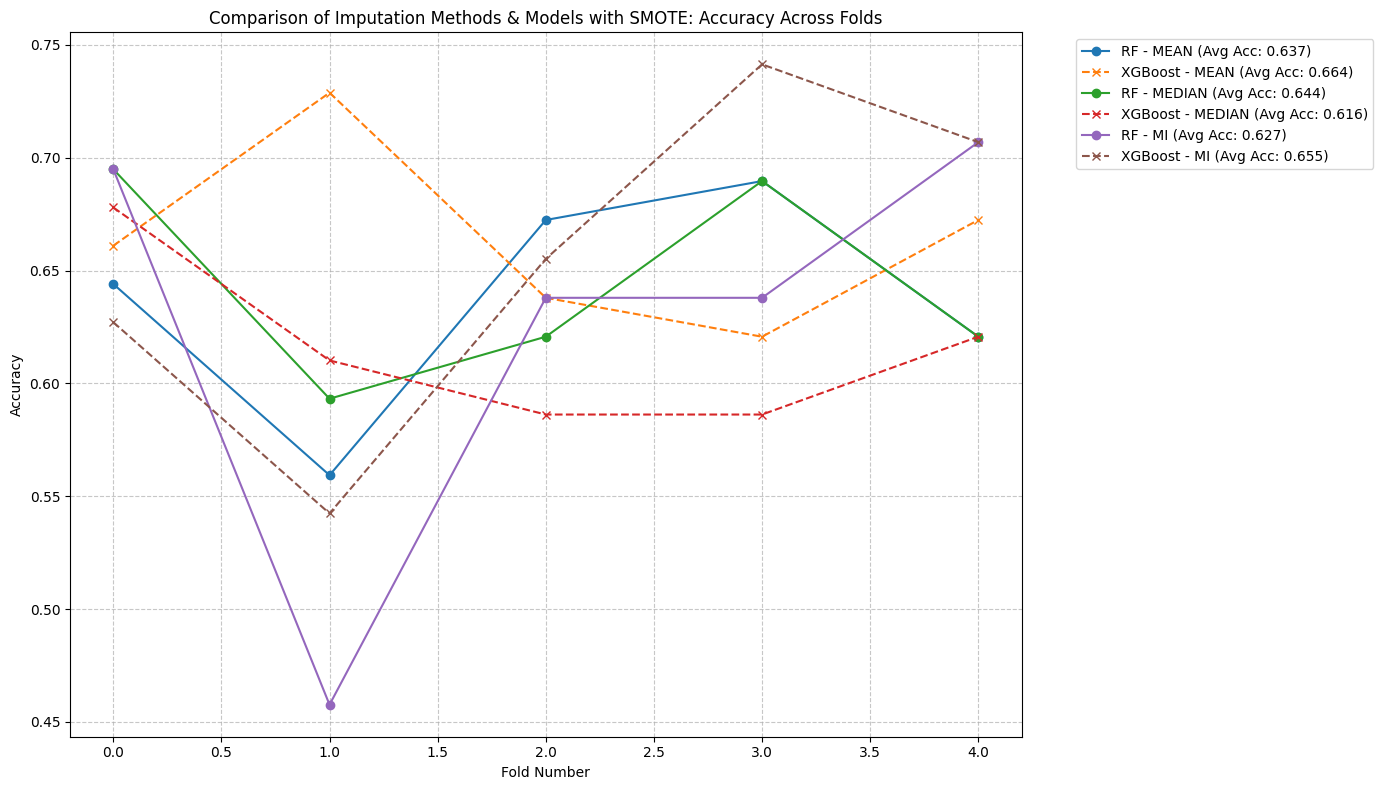

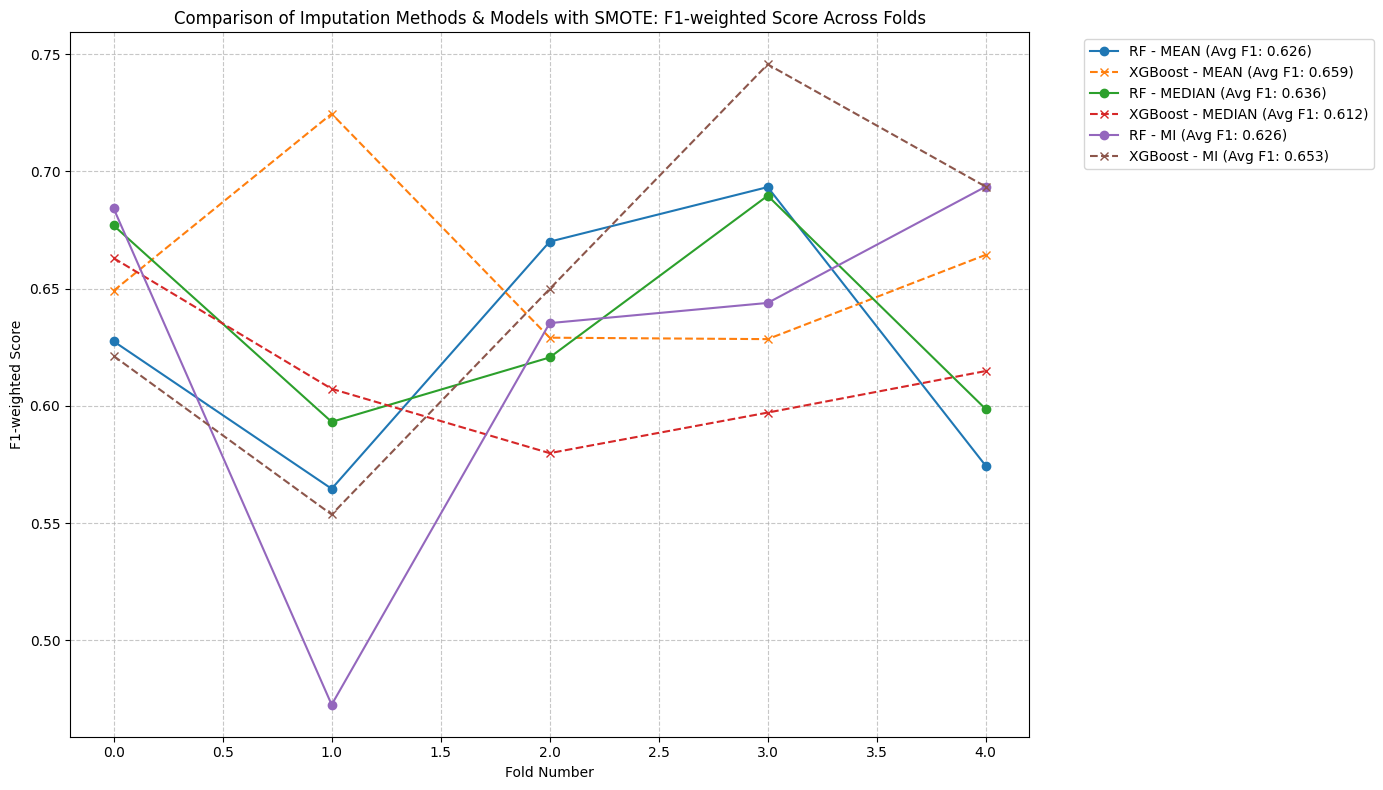


--- SHAP Plots for Best RF and XGBoost Models with SMOTE ---
Best RF: MEDIAN (F1: 0.6358) | Best XGBoost: MEAN (F1: 0.6592)

SHAP Summary Plot for the Best Random Forest (MEDIAN Imputation):


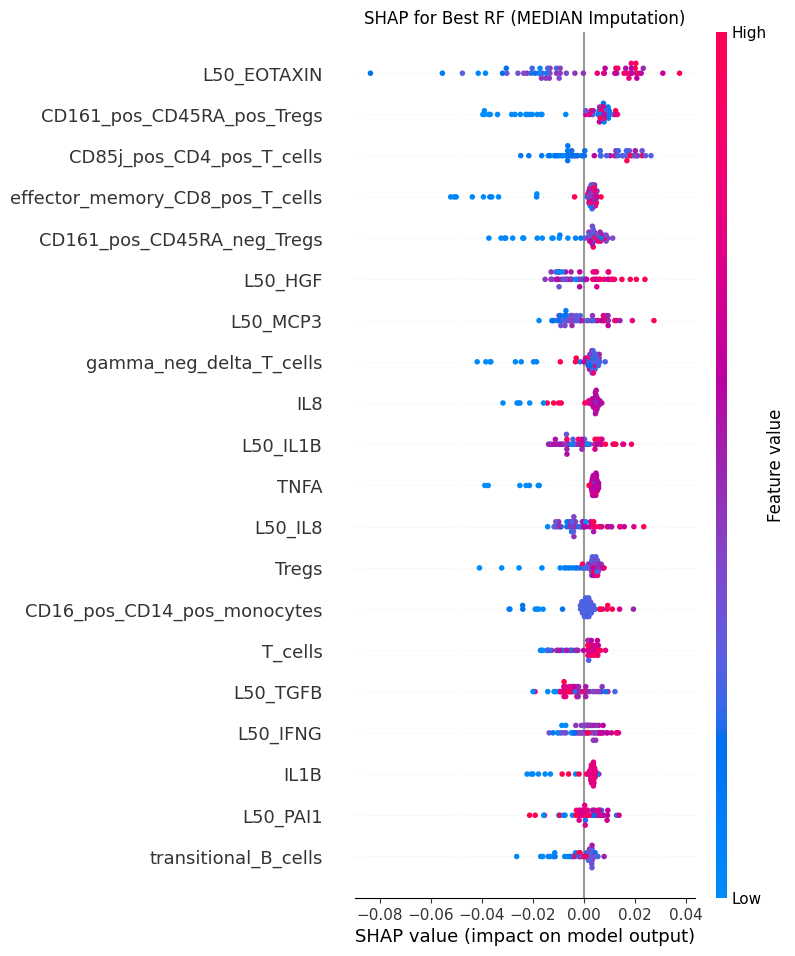


SHAP Summary Plot for the Best XGBoost (MEAN Imputation):


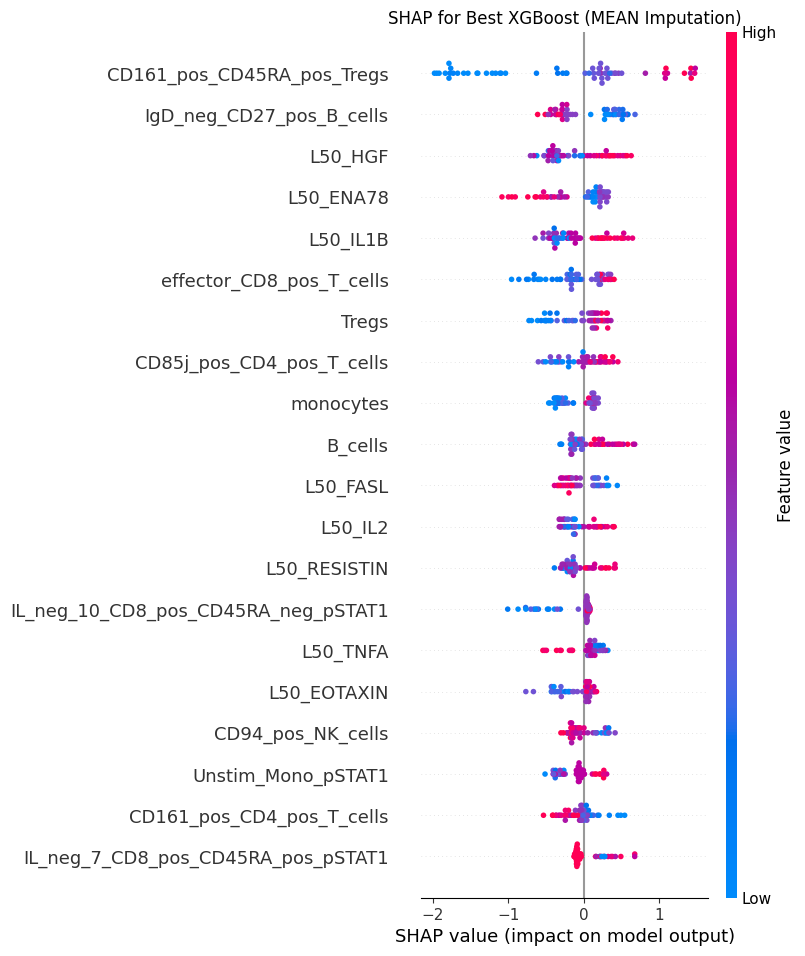

In [ ]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

def get_imputer(strategy, random_state=42):
    """Returns the appropriate imputer for a given strategy."""
    if strategy == "mean":
        return SimpleImputer(strategy="mean")
    elif strategy == "median":
        return SimpleImputer(strategy="median")
    elif strategy == "mi":
        return IterativeImputer(max_iter=10, random_state=random_state, initial_strategy="mean")
    elif strategy == "pmm":
        return IterativeImputer(max_iter=10, random_state=random_state, sample_posterior=True)
    elif strategy == "missforest":
        return IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
                                max_iter=10, random_state=random_state)
    else:
        raise ValueError("Invalid imputation strategy provided.")

# --- Define Pipelines with SMOTE for each strategy ---
smote_pipelines = {
    "mean_rf": ImbPipeline([("imputer", get_imputer("mean")),
                            ("scaler", StandardScaler()),
                            ("smote", SMOTE(random_state=42)),
                            ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1))]),
    "mean_xgb": ImbPipeline([("imputer", get_imputer("mean")),
                             ("scaler", StandardScaler()),
                             ("smote", SMOTE(random_state=42)),
                             ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=1))]),
    "median_rf": ImbPipeline([("imputer", get_imputer("median")),
                              ("scaler", StandardScaler()),
                              ("smote", SMOTE(random_state=42)),
                              ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1))]),
    "median_xgb": ImbPipeline([("imputer", get_imputer("median")),
                               ("scaler", StandardScaler()),
                               ("smote", SMOTE(random_state=42)),
                               ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=1))]),
    "mi_rf": ImbPipeline([("imputer", get_imputer("mi")),
                          ("scaler", StandardScaler()),
                          ("smote", SMOTE(random_state=42)),
                          ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1))]),
    "mi_xgb": ImbPipeline([("imputer", get_imputer("mi")),
                           ("scaler", StandardScaler()),
                           ("smote", SMOTE(random_state=42)),
                           ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=1))]),
}

# Dictionary to store results
results_smote = {
    "mean": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
    "median": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
    "mi": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
}

# Variables to track the best models
best_rf_f1_score = -1
best_rf_strategy = ""
best_xgb_f1_score = -1
best_xgb_strategy = ""

# Dictionaries to store trained pipelines and fold data
trained_pipelines = {key: [] for key in smote_pipelines.keys()}
fold_data = {}

print(f"--- Running {n_splits}-Fold Cross-Validation with SMOTE for Each Strategy ---")

for fold, (train_index, test_index) in enumerate(skf.split(X_filtered, y)):
    X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    fold_data[fold] = {"X_test": X_test, "y_test": y_test}

    print(f"\n--- Fold {fold + 1}/{n_splits} ---")

    for strategy_key, pipeline in smote_pipelines.items():
        strategy_name = strategy_key.split("_")[0]
        model_name = strategy_key.split("_")[1]

        # Clone the pipeline to ensure each fold has a fresh instance (avoids data leakage)
        cloned_pipeline = clone(pipeline)
        
        try:
            cloned_pipeline.fit(X_train, y_train)
            y_pred = cloned_pipeline.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            f1_weighted = f1_score(y_test, y_pred, average="weighted")
            
            # Store results and the trained pipeline
            results_smote[strategy_name][f"{model_name}_accuracies"].append(accuracy)
            results_smote[strategy_name][f"{model_name}_f1_weighted"].append(f1_weighted)
            trained_pipelines[strategy_key].append(cloned_pipeline)
            
        except ValueError as e:
            print(f"Error for {strategy_key} in fold {fold + 1}: {e}")
            results_smote[strategy_name][f"{model_name}_accuracies"].append(0)
            results_smote[strategy_name][f"{model_name}_f1_weighted"].append(0)
            trained_pipelines[strategy_key].append(None)

# Find the best models and their SHAP data
best_rf_shap_data = {"X_test": None, "rf_values": None, "strategy": None}
best_xgb_shap_data = {"X_test": None, "xgb_values": None, "strategy": None}

for strategy_key, pipeline_list in trained_pipelines.items():
    strategy_name = strategy_key.split("_")[0]
    model_name = strategy_key.split("_")[1]
    
    avg_f1 = np.mean([score for score in results_smote[strategy_name][f"{model_name}_f1_weighted"] if score is not None])
    
    if model_name == "rf" and avg_f1 > best_rf_f1_score:
        best_rf_f1_score = avg_f1
        best_rf_strategy = strategy_name
        # Find the specific fold with the highest F1-score for this model
        best_fold_idx = np.argmax(results_smote[strategy_name][f"{model_name}_f1_weighted"])
        best_rf_pipeline = pipeline_list[best_fold_idx]
        best_rf_X_test = fold_data[best_fold_idx]["X_test"]
        
        # Get preprocessed X_test from the pipeline (excluding SMOTE and classifier)
        if best_rf_pipeline:
            preprocessed_X_test = ImbPipeline(best_rf_pipeline.steps[:-2]).transform(best_rf_X_test)
            explainer = shap.TreeExplainer(best_rf_pipeline.named_steps["classifier"])
            shap_values = explainer.shap_values(preprocessed_X_test)
            best_rf_shap_data = {
                "X_test": pd.DataFrame(preprocessed_X_test, columns=X_filtered.columns),
                "rf_values": shap_values,
                "strategy": best_rf_strategy
            }
            
    elif model_name == "xgb" and avg_f1 > best_xgb_f1_score:
        best_xgb_f1_score = avg_f1
        best_xgb_strategy = strategy_name
        best_fold_idx = np.argmax(results_smote[strategy_name][f"{model_name}_f1_weighted"])
        best_xgb_pipeline = pipeline_list[best_fold_idx]
        best_xgb_X_test = fold_data[best_fold_idx]["X_test"]

        if best_xgb_pipeline:
            preprocessed_X_test = ImbPipeline(best_xgb_pipeline.steps[:-2]).transform(best_xgb_X_test)
            explainer = shap.TreeExplainer(best_xgb_pipeline.named_steps["classifier"])
            shap_values = explainer.shap_values(preprocessed_X_test)
            best_xgb_shap_data = {
                "X_test": pd.DataFrame(preprocessed_X_test, columns=X_filtered.columns),
                "xgb_values": shap_values,
                "strategy": best_xgb_strategy
            }

# --- Cross-Validation Summary ---
print("\n" + "="*40)
print("--- Cross-Validation Summary (with SMOTE) ---")
print("="*40)

for strategy, model_results in results_smote.items():
    print(f"\n--- Imputation Method: {strategy.upper()} ---")
    
    # Print Accuracy scores
    print(f"  Random Forest Average Accuracy: {np.mean(model_results["rf_accuracies"]):.4f} +/- {np.std(model_results["rf_accuracies"]):.4f}")
    print(f"  XGBoost Average Accuracy: {np.mean(model_results["xgb_accuracies"]):.4f} +/- {np.std(model_results["xgb_accuracies"]):.4f}")
    
    # Print F1-weighted scores
    print(f"  Random Forest Average F1-weighted: {np.mean(model_results["rf_f1_weighted"]):.4f} +/- {np.std(model_results["rf_f1_weighted"]):.4f}")
    print(f"  XGBoost Average F1-weighted: {np.mean(model_results["xgb_f1_weighted"]):.4f} +/- {np.std(model_results["xgb_f1_weighted"]):.4f}")
# --- Plotting ---
print("\n--- Generating Comparison Plots (Accuracy & F1-weighted) ---")

# Plot 1: Accuracy Comparison
plt.figure(figsize=(14, 8))
imputation_strategies = list(results_smote.keys())
for method in imputation_strategies:
    plt.plot(results_smote[method]["rf_accuracies"], marker="o", linestyle="-",
             label=f"RF - {method.upper()} (Avg Acc: {np.mean(results_smote[method]["rf_accuracies"]):.3f})")
    plt.plot(results_smote[method]["xgb_accuracies"], marker="x", linestyle="--",
             label=f"XGBoost - {method.upper()} (Avg Acc: {np.mean(results_smote[method]["xgb_accuracies"]):.3f})")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Comparison of Imputation Methods & Models with SMOTE: Accuracy Across Folds")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: F1-weighted Comparison
plt.figure(figsize=(14, 8))
for method in imputation_strategies:
    plt.plot(results_smote[method]["rf_f1_weighted"], marker="o", linestyle="-",
             label=f"RF - {method.upper()} (Avg F1: {np.mean(results_smote[method]["rf_f1_weighted"]):.3f})")
    plt.plot(results_smote[method]["xgb_f1_weighted"], marker="x", linestyle="--",
             label=f"XGBoost - {method.upper()} (Avg F1: {np.mean(results_smote[method]["xgb_f1_weighted"]):.3f})")
plt.xlabel("Fold Number")
plt.ylabel("F1-weighted Score")
plt.title("Comparison of Imputation Methods & Models with SMOTE: F1-weighted Score Across Folds")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- SHAP Plots ---
print("\n" + "="*40)
print(f"--- SHAP Plots for Best RF and XGBoost Models with SMOTE ---")
print(f"Best RF: {best_rf_strategy.upper()} (F1: {best_rf_f1_score:.4f}) | Best XGBoost: {best_xgb_strategy.upper()} (F1: {best_xgb_f1_score:.4f})")
print("="*40)

# RF SHAP plot
if best_rf_shap_data["rf_values"] is not None:
    print(f"\nSHAP Summary Plot for the Best Random Forest ({best_rf_shap_data["strategy"].upper()} Imputation):")
    # For multiclass, SHAP values are a list or 3D array; we typically want the values for the positive class (class 1)
    if isinstance(best_rf_shap_data["rf_values"], list):
        shap_values_rf_for_plot = best_rf_shap_data["rf_values"][1]
    else:
        # This case handles a 3D array (shap values, instances, features)
        shap_values_rf_for_plot = best_rf_shap_data["rf_values"][:, :, 1]
    
    shap.summary_plot(shap_values_rf_for_plot, best_rf_shap_data["X_test"], show=False)
    plt.title(f"SHAP for Best RF ({best_rf_shap_data["strategy"].upper()} Imputation)")
    plt.show()
else:
    print("SHAP values for the best RF model were not collected.")

# XGB SHAP plot
if best_xgb_shap_data["xgb_values"] is not None:
    print(f"\nSHAP Summary Plot for the Best XGBoost ({best_xgb_shap_data["strategy"].upper()} Imputation):")
    shap_values_xgb = best_xgb_shap_data["xgb_values"]
    if isinstance(shap_values_xgb, list) and len(shap_values_xgb) > 1:
        shap_values_xgb_for_plot = shap_values_xgb[1]
    elif isinstance(shap_values_xgb, np.ndarray) and shap_values_xgb.ndim == 3:
        shap_values_xgb_for_plot = shap_values_xgb[:, :, 1]
    else:
        shap_values_xgb_for_plot = shap_values_xgb
    
    shap.summary_plot(shap_values_xgb_for_plot, best_xgb_shap_data["X_test"], show=False)
    plt.title(f"SHAP for Best XGBoost ({best_xgb_shap_data["strategy"].upper()} Imputation)")
    plt.show()
else:
    print("SHAP values for the best XGBoost model were not collected.")

## Comment:
The warings just mean that the model converged before reaching the plateau (no significant improvement in the result). To overcome this we can increase the n_iter which would increase the number of iteration for each model, but this would also increase the time it takes to run. We are aiming for a balance, rather than extreme accuracy. We have tried this before (data and code not shown) but it did not increase/decrease the output by much. We are talking 0.01 or less difference.

---

## Step 4: Model Evaluation with Confusion Matrices, ROC Curves, and Log-Loss

To assess the performance of our best models (identified in the previous step), we can perform additional evaluations on the final test fold:

- **Confusion Matrices:**  
  Visualise true vs. predicted class counts for Random Forest and XGBoost with the best imputation strategy and SMOTE. This reveals patterns of classification errors and overall class-wise performance. A good model will maximise true positives and true negatives while minimising false positives and false negatives. Imbalanced datasets often lead to bias, so this detailed view helps verify if SMOTE and imputation effectively mitigate imbalance.

- **Receiver Operating Characteristic (ROC) Curves and AUC:**  
  ROC curves plot the trade-off between sensitivity (True Positive Rate) and 1 - specificity (False Positive Rate) across thresholds. The Area Under the Curve (AUC) quantifies overall classification ability regardless of threshold, with higher values indicating better discrimination. Higher AUC scores suggest better model capability to rank positive instances higher than negative ones. The plotted curves visually demonstrate the trade-off between sensitivity and specificity as thresholds move.

- **Log-Loss:**  
  Log-loss evaluates how well the predicted probabilities align with true class labels, penalising overconfident wrong predictions more heavily. It provides a complementary probabilistic performance metric to accuracy and F1-scores.

## Confusion matrix

--- Training and Evaluating Random Forest (Median Imputation + SMOTE) ---


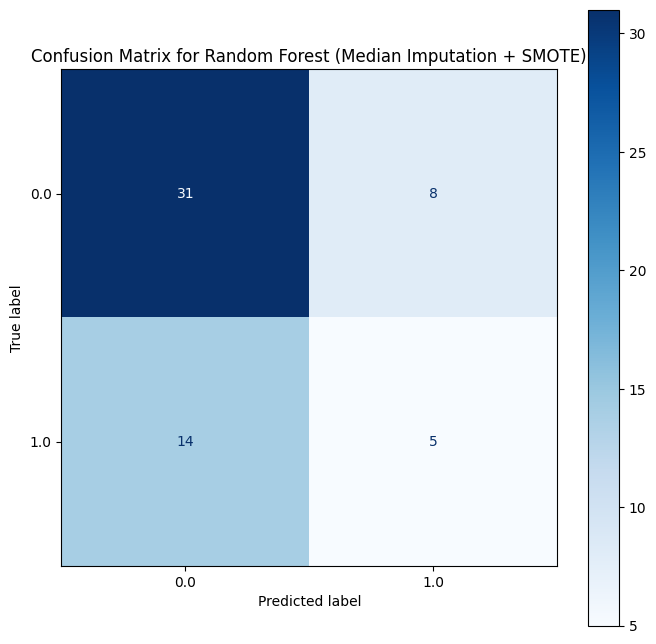



--- Training and Evaluating XGBoost (Mean Imputation + SMOTE) ---


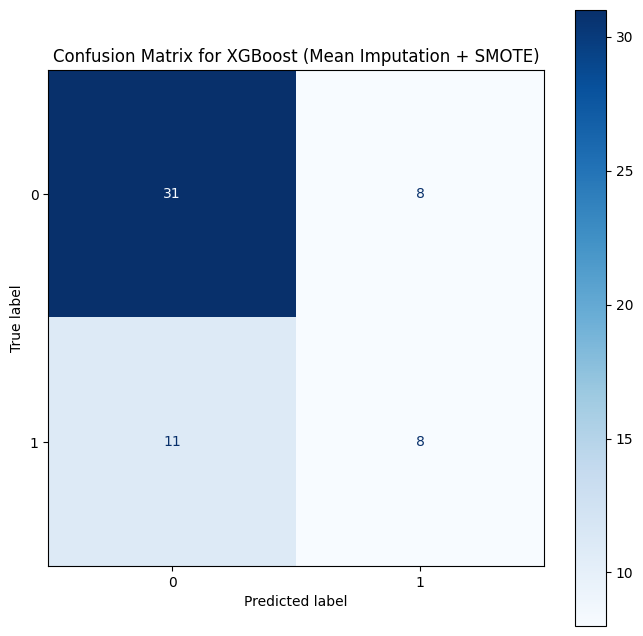

In [ ]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get the data for the final fold (last fold of the cross-validation)
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]


# --- Define Pipelines for Median Imputation with SMOTE ---
smote_median_pipelines = {
    "median_rf": ImbPipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "median_xgb": ImbPipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))
    ])
}


# --- Train and Evaluate the RF Median + SMOTE Model ---
print("--- Training and Evaluating Random Forest (Median Imputation + SMOTE) ---")
rf_median_smote_pipeline = smote_median_pipelines["median_rf"]
rf_median_smote_pipeline.fit(X_train_final, y_train_final)
y_pred_rf = rf_median_smote_pipeline.predict(X_test_final)

# Create and plot the Confusion Matrix for RF
cm_rf = confusion_matrix(y_test_final, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_median_smote_pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for Random Forest (Median Imputation + SMOTE)")
plt.show()

print("\n")


# --- Train and Evaluate the XGBoost Median + SMOTE Model ---
print("--- Training and Evaluating XGBoost (Mean Imputation + SMOTE) ---")
xgb_median_smote_pipeline = smote_median_pipelines["median_xgb"]
xgb_median_smote_pipeline.fit(X_train_final, y_train_final)
y_pred_xgb = xgb_median_smote_pipeline.predict(X_test_final)

# Create and plot the Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test_final, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_median_smote_pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for XGBoost (Mean Imputation + SMOTE)")
plt.show()


## ROC and AUC

--- Evaluating Random Forest (Median Imputation) ---
Random Forest AUC: 0.6680
--- Evaluating XGBoost (Mean Imputation) ---
XGBoost AUC: 0.6410


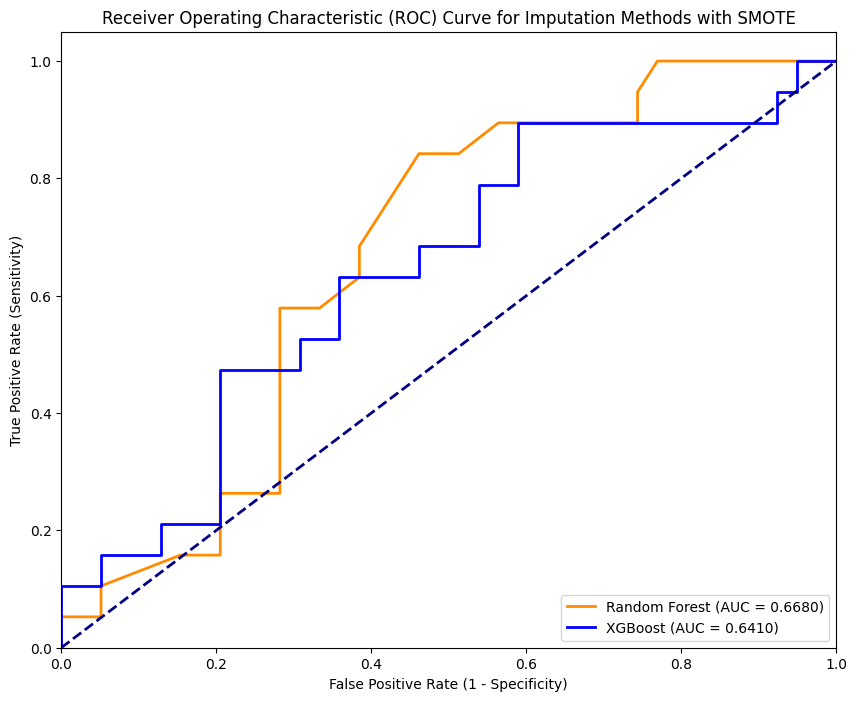

In [ ]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines for Median Imputation with SMOTE ---
smote_pipelines = {
    "rf": ImbPipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "xgb": ImbPipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))
    ])
}

# Get the data for the final fold (last fold of the cross-validation)
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# --- Train and Evaluate the RF Median Imputation Model ---
print("--- Evaluating Random Forest (Median Imputation) ---")
rf_pipeline = smote_pipelines["rf"]
rf_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for the positive class
y_proba_rf = rf_pipeline.predict_proba(X_test_final)[:, 1]

# Calculate ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test_final, y_proba_rf)
auc_rf = roc_auc_score(y_test_final, y_proba_rf)
print(f"Random Forest AUC: {auc_rf:.4f}")

# --- Train and Evaluate the XGBoost Mean Imputation Model ---
print("--- Evaluating XGBoost (Mean Imputation) ---")
xgb_pipeline = smote_pipelines["xgb"]
xgb_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for the positive class
y_proba_xgb = xgb_pipeline.predict_proba(X_test_final)[:, 1]

# Calculate ROC curve and AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_final, y_proba_xgb)
auc_xgb = roc_auc_score(y_test_final, y_proba_xgb)
print(f"XGBoost AUC: {auc_xgb:.4f}")

# --- Plotting the ROC Curves ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2, label=f"Random Forest (AUC = {auc_rf:.4f})")
plt.plot(fpr_xgb, tpr_xgb, color="blue", lw=2, label=f"XGBoost (AUC = {auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Receiver Operating Characteristic (ROC) Curve for Imputation Methods with SMOTE")
plt.legend(loc="lower right")
plt.show()

## Log-loss

In [ ]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# --- Define Pipelines for the Mean Imputation Models with SMOTE ---
smote_mean_pipelines = {
    "mean_rf": ImbPipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "mean_xgb": ImbPipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))
    ])
}

# Get the data for the final fold (last fold of the cross-validation)
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]


# --- Train and Evaluate the RF Mean + SMOTE Model ---
print("--- Evaluating Random Forest (Median Imputation + SMOTE) ---")
rf_smote_pipeline = smote_mean_pipelines["mean_rf"]
rf_smote_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for all classes
y_proba_rf_smote = rf_smote_pipeline.predict_proba(X_test_final)

# Calculate and print log-loss
logloss_rf_smote = log_loss(y_test_final, y_proba_rf_smote)
print(f"Random Forest Mean + SMOTE Log-Loss: {logloss_rf_smote:.4f}")


# --- Train and Evaluate the XGBoost Mean + SMOTE Model ---
print("\n--- Evaluating XGBoost (Mean Imputation + SMOTE) ---")
xgb_smote_pipeline = smote_mean_pipelines["mean_xgb"]
xgb_smote_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for all classes
y_proba_xgb_smote = xgb_smote_pipeline.predict_proba(X_test_final)

# Calculate and print log-loss
logloss_xgb_smote = log_loss(y_test_final, y_proba_xgb_smote)
print(f"XGBoost Mean + SMOTE Log-Loss: {logloss_xgb_smote:.4f}")

--- Evaluating Random Forest (Median Imputation + SMOTE) ---
Random Forest Mean + SMOTE Log-Loss: 0.5921

--- Evaluating XGBoost (Mean Imputation + SMOTE) ---
XGBoost Mean + SMOTE Log-Loss: 0.9335
